<a href="https://colab.research.google.com/github/hvhq/appcomponents/blob/main/ncov_AppliedMath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests as rqs
import pandas as pd
import numpy as np
import csv
from datetime import datetime, date, timedelta
import random
import matplotlib.pyplot as plt

#Install Geopandas and Geoplot
!pip install git+git://github.com/geopandas/geopandas.git
!apt install proj-bin libproj-dev libgeos-dev
!pip install git+git://github.com/ResidentMario/geoplot.git

import geopandas as gpd
import geoplot as gplt
import mapclassify as mc
import warnings
warnings.filterwarnings('ignore')

firstDay = "2021-04-27"
lastDay = "2021-07-05"

  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-n8r71pz9
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-n8r71pz9
  Created wheel for geopandas: filename=geopandas-0.9.0+45.g77a041f-py2.py3-none-any.whl size=997388 sha256=9b02339b16503b5a905bc3e5a8f46a2fb13c4acfe94ec4541b4cdf65062b98a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-qpaoalvy/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Cloning git://github.com/ResidentMario/geoplot.git to /tmp/pip-req-build-bd70tpt0
  Running command git clone -q git://github.com/ResidentMario/geoplot.git /tmp/pip-r

In [2]:
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/by-current?start_time="+firstDay+"&end_time="+"2021-07-09")

responseJsonList = response.json()
table = [["ma_tinh", "tinh","ngay","so_ca"]]
countSpreadRate = 0
sumSpreadRate = 0.0
for province in responseJsonList:
  col0 = province["id"]
  col1 = province["tinh"]
  data = province["data"]
  prevInfected = 1
  for datarow in data:
    row = [col0, col1, datarow, data[datarow]]
    table.insert(len(table), row)
    #calc spread rate
    if data[datarow] / prevInfected>0.01:
      countSpreadRate += 1
      sumSpreadRate += data[datarow] / prevInfected
    prevInfected = data[datarow]
    if prevInfected == 0:
      prevInfected = 1

with open("covid-province-data-daily.csv",  "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(table)

#average spread rate
sumSpreadRate = sumSpreadRate/countSpreadRate
print("Evaluate spreadRate of Vietnam:", sumSpreadRate)


Evaluate spreadRate of Vietnam: 2.284829765677968


In [3]:
from google.colab import files
import csv

#Load Data
#Load population data
files.upload()
#Load province mapping
files.upload()

with open('danso2019.csv', newline='') as csvfile:
  populations = list(csv.reader(csvfile))
print(populations[0])

#Load covid data
#files.upload()
with open('covid-province-data-daily.csv', newline='') as csvfile:
  covid = list(csv.reader(csvfile))
#print(covid[0])

with open("province_map.csv", newline='') as csvfile:
  provinceMap = list(csv.reader(csvfile))

Saving danso2019.csv to danso2019 (3).csv


Saving province_map.csv to province_map (1).csv
['tinh', 'dan_so', 'ma_vung', 'ten_vung']


In [4]:

with open("province_map.csv", newline='') as csvfile:
  provinceMap = list(csv.reader(csvfile))

In [5]:
# Get Geomap
GEO_URL = 'http://opendata.hcmgis.vn/geoserver/ows?srsName=EPSG%3A4326&outputFormat=json&service=WFS&srs=EPSG%3A4326&request=GetFeature&typename=geonode%3Avietnam_province_border_polygon&version=1.0.0'
geo = gpd.read_file(GEO_URL)

# Just get Name and geometry column
geo_map = geo[['Name', 'geometry']]

In [6]:
#Dictionary contain areaCode of province
areaCodeDictionary = {}
#Dan so cua 6 vung
areaPopulation = np.array([0,0,0,0,0,0])
for row in range(1,len(populations)):
  areaPopulation[int(populations[row][2]) - 1] += 1000 * float(populations[row][1].replace(",","."))
  areaCodeDictionary[populations[row][0]] = int(populations[row][2])
print("Population 2019:",areaPopulation)
#calculate end of 2020 population, roughly 2021 population
increaseRate = [1.33, 0.69, 0.69, 1.33, 2.57, 0.05]
for areaCode in range(0, 6):
  areaPopulation[areaCode] = areaPopulation[areaCode] * (1+increaseRate[areaCode]/100)
print("Population 2020: ", areaPopulation)
print("Vietnam population 2020 (calculated):",sum(areaPopulation))
print("Vietnam population end of 2020 (government stats):", 97.58 , "million")
print("So we can assume that in started months of year 2021,\n\t "
      +"population has slightly increase from 97.58 million to 97.638 milion,\n\t "
      +"so we can use that population for started months of 2021 (now) instead of 2020,\n\t"
      +"the error can be tolerated")
#Theo uoc tinh cua tong cuc thong ke, cuoi nam 2020, dan so VietNam khoang 97.58 trieu nguoi
#Điều này xác nhận tính toán của chúng ta là gần đúng 97.638, có thể chấp nhận

#Ước lượng lưu lượng di chuyển hằng ngày của 6 vùng, 2020
#Nghien cuu VITRANSS 2, thuc hien 2010
#https://openjicareport.jica.go.jp/pdf/12000063_04.pdf
flow_passenger = np.array([[0, 31864, 5044, 4263, 24738, 3121], 
                  [31864, 0, 16183, 1965, 9950, 420],
                  [5044, 16183, 0, 5969, 26005, 1816],
                  [4263, 1965, 5969, 0, 4485, 934],
                  [24738, 9950, 26005, 4485, 0, 127417],
                  [3121, 420, 1816, 934, 127417, 0]])

Population 2019: [35189500 10932800  9287600  5861300 17930300 17282500]
Population 2020:  [35657520 11008236  9351684  5939255 18391108 17291141]
Vietnam population 2020 (calculated): 97638944
Vietnam population end of 2020 (government stats): 97.58 million
So we can assume that in started months of year 2021,
	 population has slightly increase from 97.58 million to 97.638 milion,
	 so we can use that population for started months of 2021 (now) instead of 2020,
	the error can be tolerated


In [7]:
#build test data
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
dailyCaseInAreas = np.zeros((delta.days + 1, 6))
for row in range(1, len(covid)):
  strday = covid[row][2]
  day = datetime.strptime(strday, "%Y-%m-%d").date()
  index = (day - sdate).days
  if index < 0 or index > delta.days:
    continue
  provinceName = covid[row][1]
  areaCode = areaCodeDictionary[provinceName]
  dailyCaseInAreas[index, areaCode - 1] += int(covid[row][3])


Initial State
S: [35653810. 11008170.  9350711.  5939255. 18390641. 17290895.]
I: [871.  10.  23.   0.   7.  48.]
R: [2839.   56.  950.    0.  460.  198.]


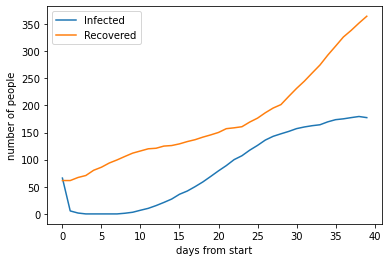

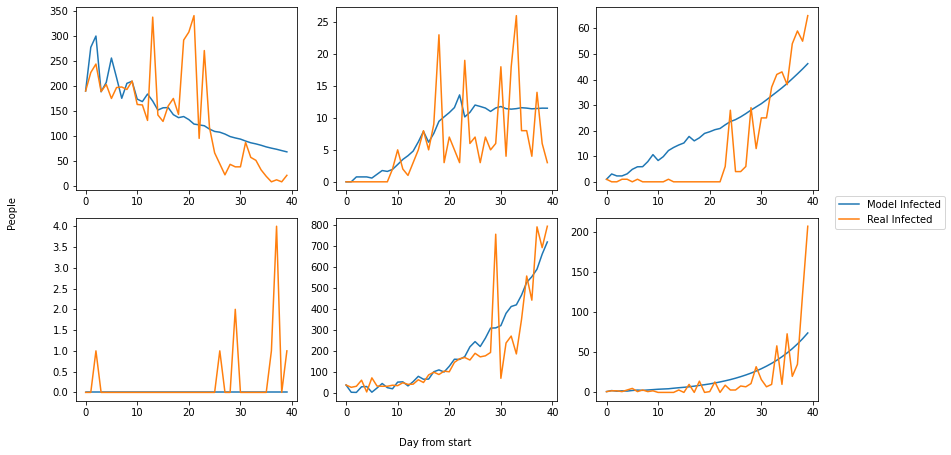

In [9]:
#Find parameters that match the training data (data from day 2021-05-27 to day 2021-07-05)
#Because there are many variable like when a province/city is distancing,
#   when the disease become serious, many people come and help to trace, test, and cure people...
#   so for simplicity, we use training data and find some parameter that help the model match the training data
#   after this, we can use those parameter to guess the disease status of the next few days

#time that a infected person can spread the disease
beginSpread = 2
#detect day: day that person infected is detected from the day he/she get the disease
maxDetectDay = 7
averageDetectDay = 5
detectDay = [5, 6, 6, 6, 5, 6]
#number of day he/she spread disease to other people
spreadRange = averageDetectDay - beginSpread
#There is no need to save S in SIR because S+I+R=N (constant)
Ss = np.array([S])
Is = np.empty((0, 6))
Rs = np.empty((0, 6))
#get some data of previous day as input
sdate = date(2021, 5, 27 - maxDetectDay + 1)   # start date
edate = date(2021, 5, 27)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  I = np.array([0,0,0,0,0,0])
  R = np.array([0,0,0,0,0,0])
  response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+str(day)).json()
  response = response['rows']
  for row in range(len(response)):
    provinceName = response[row]["tinh"]
    areaCode = areaCodeDictionary[provinceName]
    R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
    I[areaCode - 1] += response[row]["so_ca"]
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
#get new infected data of previous few days
NewInfecteds = np.zeros((delta.days + 1, 6))
for row in range(1, len(covid)):
  strday = covid[row][2]
  day = datetime.strptime(strday, "%Y-%m-%d").date()
  index = (day - sdate).days
  if index < 0 or index >= maxDetectDay:
    continue
  provinceName = covid[row][1]
  areaCode = areaCodeDictionary[provinceName]
  NewInfecteds[index, areaCode - 1] += int(covid[row][3])
#First day S, I and R
I = Is[len(Is) - 1]
R = Rs[len(Rs) - 1]
S = np.array(areaPopulation) - I
I = I - R
print("Initial State")
print("S:", S)
print("I:",I)
print("R:", R)

#Those parameter below was selected from several test to match the training data
spreadRate = [1.33 /spreadRange, 2.3 /spreadRange, 2.3 /spreadRange, 2.3/spreadRange, 2.3/spreadRange, 2.3/spreadRange]
#[6000, 1] mean in area 1, thay decide to anounce distancing level 1 when active covid case is 6000,
# and the spreadRate reduce to 1, 
# when the covid case more than 10000, they decide to distancing level 2
# and the spreadRate reduce to 0.7
# Again they was selected after several test to best match the training data
spreadRateScale = np.array([[[6000, 1], [10000, 0.7]],
                            [[30, 1.5], [100, 1]],
                            [[15, 1.5], [100, 1.2]],
                            [[15, 1.5], [30, 1.2]],
                            [[1500, 2], [6000, 1.2]],
                            [[15, 1.5], [1000, 1.2]],
                            ])
#The rate of I change to R every day
recoverRate = 1/14
sdate = date(2021, 5, 28) 
edate = date(2021, 7, 5)  
delta = edate - sdate   
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area1 in range(5):
    for area2 in range(area1 + 1, 6):
      #probability of 1 people leaves the region area1 and come to region area2
      onePersonProb = (flow_passenger[area1, area2]/2)/areaPopulation[area1]
      #count number leave region 1 and come to region 2
      if (I[area1] > 0):
        countILeave = np.random.binomial(I[area1], onePersonProb)
      else:
        countILeave = 0
      countRLeave = np.random.binomial(R[area1], onePersonProb)
      #probability of 1 people leaves the region area2 and come to region area1
      onePersonProb = (flow_passenger[area1, area2]/2)/areaPopulation[area2]
      #count number come to region 1 from region 2
      if I[area2] > 0:
        countICome = np.random.binomial(I[area2], onePersonProb)
      else:
        countICome = 0
      countRCome = np.random.binomial(R[area2], onePersonProb)
      #arrived
      I[area1] += countICome - countILeave
      I[area2] += countILeave - countICome
      R[area1] += countRCome - countRLeave
      R[area2] += countRLeave - countRCome
      S[area1] = areaPopulation[area1] - I[area1] - R[area1]
      S[area2] = areaPopulation[area2] - I[area2] - R[area2]
  #SIR evolution
  NewInfecteds = np.insert(NewInfecteds, len(NewInfecteds), [0,0,0,0,0,0], axis=0)
  #for each region
  for area in range(6):
    startTime = len(NewInfecteds) - detectDay[area]
    endTime = len(NewInfecteds) - 1 - beginSpread
    if startTime < 0:
      startTime = 0
    if endTime < startTime:
      endTime = startTime
    affectPerson = sum(NewInfecteds[startTime:endTime, area])
    newInfected = spreadRate[area] * S[area] / areaPopulation[area] * affectPerson
    recovered = recoverRate * Is[i, area]
    #update
    NewInfecteds[len(NewInfecteds)-1, area] = newInfected
    R[area] += recovered
    I[area] += newInfected - recovered
    if I[area] < 0:
      I[area] = 0
    S[area] = areaPopulation[area] - I[area] - R[area]
    if I[area] > spreadRateScale[area, 0, 0]:
      spreadRate[area] = spreadRateScale[area, 0,1] / (averageDetectDay - beginSpread)
    if I[area] > spreadRateScale[area, 1, 0]:
      spreadRate[area] = spreadRateScale[area, 1,1] / (averageDetectDay - beginSpread)
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
NewInfecteds = np.delete(NewInfecteds, range(maxDetectDay-1), axis=0)
#plt.plot(range((edate - sdate).days + 1+1),Ss[:,4], label="Suspected")
plt.plot(range((edate - sdate).days + 1+1),Is[maxDetectDay-1:,1], label="Infected")
plt.plot(range((edate - sdate).days + 1+1),Rs[maxDetectDay-1:,1], label="Recovered")
plt.xlabel("days from start")
plt.ylabel("number of people")
plt.legend()
plt.show()

sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(11,6)
fig.text(0.5, -0.04, 'Day from start', ha='center')
fig.text(-0.04, 0.5, 'People', va='center', rotation='vertical')
axs[0,0].plot(range((edate - sdate).days + 1),NewInfecteds[:,0], label="Model Infected")
axs[0,0].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 0], label="Real Infected")

axs[0,1].plot(range((edate - sdate).days + 1),NewInfecteds[:,1])
axs[0,1].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 1])

axs[0,2].plot(range((edate - sdate).days + 1),NewInfecteds[:,2])
axs[0,2].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 2])

axs[1,0].plot(range((edate - sdate).days + 1),NewInfecteds[:,3])
axs[1,0].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 3])

axs[1,1].plot(range((edate - sdate).days + 1),NewInfecteds[:,4])
axs[1,1].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 4])

axs[1,2].plot(range((edate - sdate).days + 1),NewInfecteds[:,5])
axs[1,2].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 5])

fig.legend(loc=0, bbox_to_anchor=(1.15,0.55), bbox_transform=fig.transFigure)
fig.tight_layout()

In [11]:
#How to use
# We group province and city to 6 area:
#       Northern, Central North, Central South, Central Highland, Southern East, Mekong River Delta.
#Input:
#   The day want to guess the infected case of 6 area (after 2021-07-05)
#   Example: 2021-07-07
#Output:
#   Infected cases and Recovered case of each area
#   Example: 
#     I: []
#     R: []   

day = input("Input a day that you want to guess disease status: ")
testday = datetime.strptime(day, "%Y-%m-%d").date()
#time that a infected person can spread the disease
beginSpread = 2
#detect day: day that person infected is detected from the day he/she get the disease
maxDetectDay = 7
averageDetectDay = 5
detectDay = [5, 6, 6, 6, 5, 6]
#number of day he/she spread disease to other people
spreadRange = averageDetectDay - beginSpread
#There is no need to save S in SIR because S+I+R=N (constant)
#Ss = np.array([S])
Is = np.empty((0, 6))
Rs = np.empty((0, 6))
#get some data of previous day as input
sdate = date(2021, 5, 27 - maxDetectDay + 1)   # start date
edate = date(2021, 5, 27)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  I = np.array([0,0,0,0,0,0])
  R = np.array([0,0,0,0,0,0])
  response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+str(day)).json()
  response = response['rows']
  for row in range(len(response)):
    provinceName = response[row]["tinh"]
    areaCode = areaCodeDictionary[provinceName]
    R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
    I[areaCode - 1] += response[row]["so_ca"]
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
#get new infected data of previous few days
NewInfecteds = np.zeros((delta.days + 1, 6))
for row in range(1, len(covid)):
  strday = covid[row][2]
  day = datetime.strptime(strday, "%Y-%m-%d").date()
  index = (day - sdate).days
  if index < 0 or index >= maxDetectDay:
    continue
  provinceName = covid[row][1]
  areaCode = areaCodeDictionary[provinceName]
  NewInfecteds[index, areaCode - 1] += int(covid[row][3])
#First day S, I and R
I = Is[len(Is) - 1]
R = Rs[len(Rs) - 1]
S = np.array(areaPopulation) - I
I = I - R

#Those parameter below was selected from several test to match the training data
spreadRate = [1.33 /spreadRange, 2.3 /spreadRange, 2.3 /spreadRange, 2.3/spreadRange, 2.3/spreadRange, 2.3/spreadRange]
#[6000, 1] mean in area 1, thay decide to anounce distancing level 1 when active covid case is 6000,
# and the spreadRate reduce to 1, 
# when the covid case more than 10000, they decide to distancing level 2
# and the spreadRate reduce to 0.7
# Again they was selected after several test to best match the training data
spreadRateScale = np.array([[[6000, 1], [10000, 0.7]],
                            [[30, 1.5], [100, 1]],
                            [[15, 1.5], [100, 1.2]],
                            [[15, 1.5], [30, 1.2]],
                            [[1500, 2], [6000, 1.2]],
                            [[15, 1.5], [1000, 1.2]],
                            ])
#The rate of I change to R every day
recoverRate = 1/14
sdate = date(2021, 5, 28) 
edate = testday
delta = edate - sdate   
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area1 in range(5):
    for area2 in range(area1 + 1, 6):
      #probability of 1 people leaves the region area1 and come to region area2
      onePersonProb = (flow_passenger[area1, area2]/2)/areaPopulation[area1]
      #count number leave region 1 and come to region 2
      if (I[area1] > 0):
        countILeave = np.random.binomial(I[area1], onePersonProb)
      else:
        countILeave = 0
      countRLeave = np.random.binomial(R[area1], onePersonProb)
      #probability of 1 people leaves the region area2 and come to region area1
      onePersonProb = (flow_passenger[area1, area2]/2)/areaPopulation[area2]
      #count number come to region 1 from region 2
      if I[area2] > 0:
        countICome = np.random.binomial(I[area2], onePersonProb)
      else:
        countICome = 0
      countRCome = np.random.binomial(R[area2], onePersonProb)
      #arrived
      I[area1] += countICome - countILeave
      I[area2] += countILeave - countICome
      R[area1] += countRCome - countRLeave
      R[area2] += countRLeave - countRCome
      S[area1] = areaPopulation[area1] - I[area1] - R[area1]
      S[area2] = areaPopulation[area2] - I[area2] - R[area2]
  #SIR evolution
  NewInfecteds = np.insert(NewInfecteds, len(NewInfecteds), [0,0,0,0,0,0], axis=0)
  #for each region
  for area in range(6):
    startTime = len(NewInfecteds) - detectDay[area]
    endTime = len(NewInfecteds) - 1 - beginSpread
    if startTime < 0:
      startTime = 0
    if endTime < startTime:
      endTime = startTime
    affectPerson = sum(NewInfecteds[startTime:endTime, area])
    newInfected = spreadRate[area] * S[area] / areaPopulation[area] * affectPerson
    recovered = recoverRate * Is[i, area]
    #update
    NewInfecteds[len(NewInfecteds)-1, area] = newInfected
    R[area] += recovered
    I[area] += newInfected - recovered
    if I[area] < 0:
      I[area] = 0
    S[area] = areaPopulation[area] - I[area] - R[area]
    if I[area] > spreadRateScale[area, 0, 0]:
      spreadRate[area] = spreadRateScale[area, 0,1] / (averageDetectDay - beginSpread)
    if I[area] > spreadRateScale[area, 1, 0]:
      spreadRate[area] = spreadRateScale[area, 1,1] / (averageDetectDay - beginSpread)
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
NewInfecteds = np.delete(NewInfecteds, range(maxDetectDay-1), axis=0)
print("Guess of the model at day", str(testday))
print("I:", I)
print("R:", R)
print("New case:", NewInfecteds[len(NewInfecteds) - 1])

Input a day that you want to guess disease status: 2021-07-06
Guess of the model at day 2021-07-06
I: [1223.09816126  189.81857548  530.20082453    8.49055081 6223.34414597
  770.45575781]
R: [7896.82171204  414.4054567  1652.06121489   40.50944919 2862.28066524
  668.92702656]
New case: [ 65.89416898  11.47293444  48.39112664   0.         759.09685108
  82.01469959]


Change distancing rule of Southern East (include HCM city)
Input number of active case you will want city to distancing level 1:1500
Input number of active case you will want city to distancing level 2:6000
Graph of I and R in Southern East


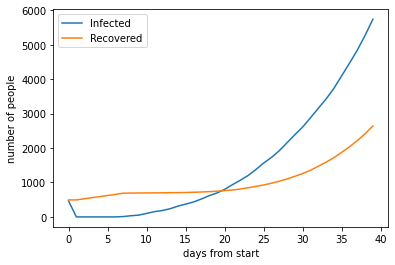

Graphs of new case everyday (start at 2021-05-27) of 6 areas
Graph of covid in regions in Vietnam,  2021-07-05


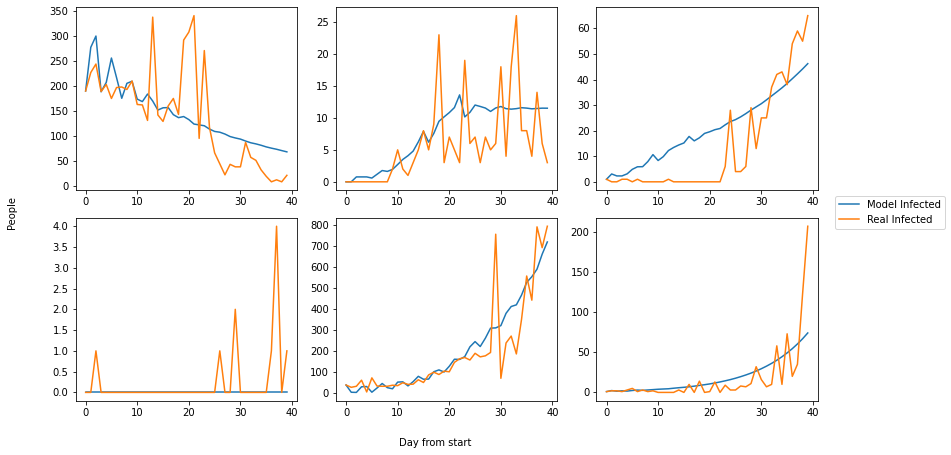

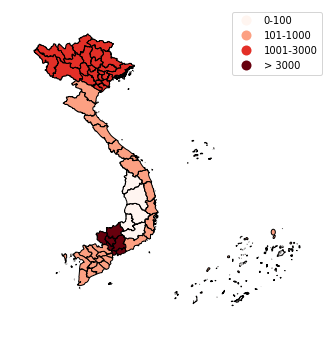

In [12]:
#So now if we focus only on the area 5, Southern East, which include Ho Chi Minh city
#What if we the city use another distancing decision rule
#What if the city decide to distancing level 1 (directive 15 of government) only when the case across 10000
#   and distancing level 2 (directive 16 of goverment) only when the case across 30000
#Or other number that belong to your input

#Input:
#   two number, first is the number of case you will want the city distancing level 1
#               second is the number of case you will want the city distancing level 2
#Output:
#   Graphs of covid new infecteds every day of 6 area, when area 5 (include HCMC) use the new rule
print("Change distancing rule of Southern East (include HCM city)")
numberLevel1 = int(input("Input number of active case you will want city to distancing level 1:"))
numberLevel2 = int(input("Input number of active case you will want city to distancing level 2:"))

#time that a infected person can spread the disease
beginSpread = 2
#detect day: day that person infected is detected from the day he/she get the disease
maxDetectDay = 7
averageDetectDay = 5
detectDay = [5, 6, 6, 6, 5, 6]
#number of day he/she spread disease to other people
spreadRange = averageDetectDay - beginSpread
#There is no need to save S in SIR because S+I+R=N (constant)
#Ss = np.array([S])
Is = np.empty((0, 6))
Rs = np.empty((0, 6))
#get some data of previous day as input
sdate = date(2021, 5, 27 - maxDetectDay + 1)   # start date
edate = date(2021, 5, 27)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  I = np.array([0,0,0,0,0,0])
  R = np.array([0,0,0,0,0,0])
  response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+str(day)).json()
  response = response['rows']
  for row in range(len(response)):
    provinceName = response[row]["tinh"]
    areaCode = areaCodeDictionary[provinceName]
    R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
    I[areaCode - 1] += response[row]["so_ca"]
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
#get new infected data of previous few days
NewInfecteds = np.zeros((delta.days + 1, 6))
for row in range(1, len(covid)):
  strday = covid[row][2]
  day = datetime.strptime(strday, "%Y-%m-%d").date()
  index = (day - sdate).days
  if index < 0 or index >= maxDetectDay:
    continue
  provinceName = covid[row][1]
  areaCode = areaCodeDictionary[provinceName]
  NewInfecteds[index, areaCode - 1] += int(covid[row][3])
#First day S, I and R
I = Is[len(Is) - 1]
R = Rs[len(Rs) - 1]
S = np.array(areaPopulation) - I
I = I - R

#Those parameter below was selected from several test to match the training data
spreadRate = [1.33 /spreadRange, 2.3 /spreadRange, 2.3 /spreadRange, 2.3/spreadRange, 2.3/spreadRange, 2.3/spreadRange]
#[6000, 1] mean in area 1, thay decide to anounce distancing level 1 when active covid case is 6000,
# and the spreadRate reduce to 1, 
# when the covid case more than 10000, they decide to distancing level 2
# and the spreadRate reduce to 0.7
# Again they was selected after several test to best match the training data
spreadRateScale = np.array([[[6000, 1], [10000, 0.7]],
                            [[30, 1.5], [100, 1]],
                            [[15, 1.5], [100, 1.2]],
                            [[15, 1.5], [30, 1.2]],
                            [[numberLevel1, 2], [numberLevel2, 1.2]],
                            [[15, 1.5], [1000, 1.2]],
                            ])
#The rate of I change to R every day
recoverRate = 1/14
sdate = date(2021, 5, 28) 
edate = date(2021, 7, 5)  
delta = edate - sdate   
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area1 in range(5):
    for area2 in range(area1 + 1, 6):
      #probability of 1 people leaves the region area1 and come to region area2
      onePersonProb = (flow_passenger[area1, area2]/2)/areaPopulation[area1]
      #count number leave region 1 and come to region 2
      if (I[area1] > 0):
        countILeave = np.random.binomial(I[area1], onePersonProb)
      else:
        countILeave = 0
      countRLeave = np.random.binomial(R[area1], onePersonProb)
      #probability of 1 people leaves the region area2 and come to region area1
      onePersonProb = (flow_passenger[area1, area2]/2)/areaPopulation[area2]
      #count number come to region 1 from region 2
      if I[area2] > 0:
        countICome = np.random.binomial(I[area2], onePersonProb)
      else:
        countICome = 0
      countRCome = np.random.binomial(R[area2], onePersonProb)
      #arrived
      I[area1] += countICome - countILeave
      I[area2] += countILeave - countICome
      R[area1] += countRCome - countRLeave
      R[area2] += countRLeave - countRCome
      S[area1] = areaPopulation[area1] - I[area1] - R[area1]
      S[area2] = areaPopulation[area2] - I[area2] - R[area2]
  #SIR evolution
  NewInfecteds = np.insert(NewInfecteds, len(NewInfecteds), [0,0,0,0,0,0], axis=0)
  #for each region
  for area in range(6):
    startTime = len(NewInfecteds) - detectDay[area]
    endTime = len(NewInfecteds) - 1 - beginSpread
    if startTime < 0:
      startTime = 0
    if endTime < startTime:
      endTime = startTime
    affectPerson = sum(NewInfecteds[startTime:endTime, area])
    newInfected = spreadRate[area] * S[area] / areaPopulation[area] * affectPerson
    recovered = recoverRate * Is[i, area]
    #update
    NewInfecteds[len(NewInfecteds)-1, area] = newInfected
    R[area] += recovered
    I[area] += newInfected - recovered
    if I[area] < 0:
      I[area] = 0
    S[area] = areaPopulation[area] - I[area] - R[area]
    if I[area] > spreadRateScale[area, 0, 0]:
      spreadRate[area] = spreadRateScale[area, 0,1] / (averageDetectDay - beginSpread)
    if I[area] > spreadRateScale[area, 1, 0]:
      spreadRate[area] = spreadRateScale[area, 1,1] / (averageDetectDay - beginSpread)
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
NewInfecteds = np.delete(NewInfecteds, range(maxDetectDay-1), axis=0)

print("Graph of I and R in Southern East")
#plt.plot(range((edate - sdate).days + 1+1),Ss[:,4], label="Suspected")
plt.plot(range((edate - sdate).days + 1+1),Is[maxDetectDay-1:,4], label="Infected")
plt.plot(range((edate - sdate).days + 1+1),Rs[maxDetectDay-1:,4], label="Recovered")
plt.xlabel("days from start")
plt.ylabel("number of people")
plt.legend()
plt.show()

print("Graphs of new case everyday (start at 2021-05-27) of 6 areas")
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(11,6)
fig.text(0.5, -0.04, 'Day from start', ha='center')
fig.text(-0.04, 0.5, 'People', va='center', rotation='vertical')
axs[0,0].plot(range((edate - sdate).days + 1),NewInfecteds[:,0], label="Model Infected")
axs[0,0].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 0], label="Real Infected")

axs[0,1].plot(range((edate - sdate).days + 1),NewInfecteds[:,1])
axs[0,1].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 1])

axs[0,2].plot(range((edate - sdate).days + 1),NewInfecteds[:,2])
axs[0,2].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 2])

axs[1,0].plot(range((edate - sdate).days + 1),NewInfecteds[:,3])
axs[1,0].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 3])

axs[1,1].plot(range((edate - sdate).days + 1),NewInfecteds[:,4])
axs[1,1].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 4])

axs[1,2].plot(range((edate - sdate).days + 1),NewInfecteds[:,5])
axs[1,2].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 5])

fig.legend(loc=0, bbox_to_anchor=(1.15,0.55), bbox_transform=fig.transFigure)
fig.tight_layout()


# Update color column
from csv import writer
from csv import reader

with open('province_map.csv', 'r') as read_obj, \
  open('Color by Province.csv', 'w', newline='') as write_obj:

  csv_reader = reader(read_obj)
  csv_writer = writer(write_obj)

  for row in csv_reader:
    if (row[-1] == 'Ten'):
      row.append('Color')
    else:
      provinceName = row[1]
      if (provinceName=="Ten"):
        continue
      areaCode = areaCodeDictionary[provinceName]
      activeCase = Is[len(Is)-1, areaCode - 1]
      if (activeCase > 3000):
        color = 3
      elif (activeCase > 1000):
        color = 2
      elif (activeCase > 100):
        color = 1
      else:
        color = 0

      row.append(color)
    csv_writer.writerow(row)
# Read color data
color_data = pd.read_csv('Color by Province.csv')
# Merge province map with province's infected cases.
geo_data = geo_map.merge(color_data, how='inner', left_on=['Name'], right_on=['Name'])
# Plot map
scheme = mc.FisherJenks(geo_data['Color'], k=4)
print("Graph of covid in regions in Vietnam, ", str(edate))
gplt.choropleth(geo_data, hue='Color', legend=True, cmap='Reds',
                scheme=scheme, 
                legend_labels=[
                    '0-100', '101-1000',
                    '1001-3000', '> 3000'
                ]
)

In [27]:
#Evaluate
#try to evaluate data from 2021-07-06 to 2021-07-06

day = "2021-07-06"
testday = datetime.strptime(day, "%Y-%m-%d").date()
#time that a infected person can spread the disease
beginSpread = 2
#detect day: day that person infected is detected from the day he/she get the disease
maxDetectDay = 7
averageDetectDay = 5
detectDay = [5, 6, 6, 6, 5, 6]
#number of day he/she spread disease to other people
spreadRange = averageDetectDay - beginSpread
#There is no need to save S in SIR because S+I+R=N (constant)
#Ss = np.array([S])
Is = np.empty((0, 6))
Rs = np.empty((0, 6))
#get some data of previous day as input
sdate = date(2021, 5, 27 - maxDetectDay + 1)   # start date
edate = date(2021, 5, 27)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  I = np.array([0,0,0,0,0,0])
  R = np.array([0,0,0,0,0,0])
  response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+str(day)).json()
  response = response['rows']
  for row in range(len(response)):
    provinceName = response[row]["tinh"]
    areaCode = areaCodeDictionary[provinceName]
    R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
    I[areaCode - 1] += response[row]["so_ca"]
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
#get new infected data of previous few days
NewInfecteds = np.zeros((delta.days + 1, 6))
for row in range(1, len(covid)):
  strday = covid[row][2]
  day = datetime.strptime(strday, "%Y-%m-%d").date()
  index = (day - sdate).days
  if index < 0 or index >= maxDetectDay:
    continue
  provinceName = covid[row][1]
  areaCode = areaCodeDictionary[provinceName]
  NewInfecteds[index, areaCode - 1] += int(covid[row][3])
#First day S, I and R
I = Is[len(Is) - 1]
R = Rs[len(Rs) - 1]
S = np.array(areaPopulation) - I
I = I - R

#Those parameter below was selected from several test to match the training data
spreadRate = [1.33 /spreadRange, 2.3 /spreadRange, 2.3 /spreadRange, 2.3/spreadRange, 2.3/spreadRange, 2.3/spreadRange]
#[6000, 1] mean in area 1, thay decide to anounce distancing level 1 when active covid case is 6000,
# and the spreadRate reduce to 1, 
# when the covid case more than 10000, they decide to distancing level 2
# and the spreadRate reduce to 0.7
# Again they was selected after several test to best match the training data
spreadRateScale = np.array([[[6000, 1], [10000, 0.7]],
                            [[30, 1.5], [100, 1]],
                            [[15, 1.5], [100, 1.2]],
                            [[15, 1.5], [30, 1.2]],
                            [[1500, 2], [6000, 1.2]],
                            [[15, 1.5], [1000, 1.2]],
                            ])
#The rate of I change to R every day
recoverRate = 1/14
sdate = date(2021, 5, 28) 
edate = testday
delta = edate - sdate   
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area1 in range(5):
    for area2 in range(area1 + 1, 6):
      #probability of 1 people leaves the region area1 and come to region area2
      onePersonProb = (flow_passenger[area1, area2]/2)/areaPopulation[area1]
      #count number leave region 1 and come to region 2
      if (I[area1] > 0):
        countILeave = np.random.binomial(I[area1], onePersonProb)
      else:
        countILeave = 0
      countRLeave = np.random.binomial(R[area1], onePersonProb)
      #probability of 1 people leaves the region area2 and come to region area1
      onePersonProb = (flow_passenger[area1, area2]/2)/areaPopulation[area2]
      #count number come to region 1 from region 2
      if I[area2] > 0:
        countICome = np.random.binomial(I[area2], onePersonProb)
      else:
        countICome = 0
      countRCome = np.random.binomial(R[area2], onePersonProb)
      #arrived
      I[area1] += countICome - countILeave
      I[area2] += countILeave - countICome
      R[area1] += countRCome - countRLeave
      R[area2] += countRLeave - countRCome
      S[area1] = areaPopulation[area1] - I[area1] - R[area1]
      S[area2] = areaPopulation[area2] - I[area2] - R[area2]
  #SIR evolution
  NewInfecteds = np.insert(NewInfecteds, len(NewInfecteds), [0,0,0,0,0,0], axis=0)
  #for each region
  for area in range(6):
    startTime = len(NewInfecteds) - detectDay[area]
    endTime = len(NewInfecteds) - 1 - beginSpread
    if startTime < 0:
      startTime = 0
    if endTime < startTime:
      endTime = startTime
    affectPerson = sum(NewInfecteds[startTime:endTime, area])
    newInfected = spreadRate[area] * S[area] / areaPopulation[area] * affectPerson
    recovered = recoverRate * Is[i, area]
    #update
    NewInfecteds[len(NewInfecteds)-1, area] = newInfected
    R[area] += recovered
    I[area] += newInfected - recovered
    if I[area] < 0:
      I[area] = 0
    S[area] = areaPopulation[area] - I[area] - R[area]
    if I[area] > spreadRateScale[area, 0, 0]:
      spreadRate[area] = spreadRateScale[area, 0,1] / (averageDetectDay - beginSpread)
    if I[area] > spreadRateScale[area, 1, 0]:
      spreadRate[area] = spreadRateScale[area, 1,1] / (averageDetectDay - beginSpread)
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
NewInfecteds = np.delete(NewInfecteds, range(maxDetectDay-1), axis=0)

sdate = date(2021, 7, 6) 
edate = date(2021, 7, 6)  
delta = edate - sdate   

with open('covid-province-data-daily.csv', newline='') as csvfile:
  covid = list(csv.reader(csvfile))
#real data
dailyCaseInAreas = np.zeros((delta.days + 1, 6))
for row in range(1, len(covid)):
  strday = covid[row][2]
  day = datetime.strptime(strday, "%Y-%m-%d").date()
  index = (day - sdate).days
  if index < 0 or index > delta.days:
    continue
  provinceName = covid[row][1]
  areaCode = areaCodeDictionary[provinceName]
  dailyCaseInAreas[index, areaCode - 1] += int(covid[row][3])

sumerror = 0.0
guess = NewInfecteds[len(NewInfecteds)  - 1]

EPS = 1e-10
for j in range(6):
  bigger = guess[j]
  if bigger < dailyCaseInAreas[0,j]:
    bigger = dailyCaseInAreas[0,j]
  if bigger <= EPS:
    bigger = 1
  error = (guess[j] - dailyCaseInAreas[0,j])/bigger
  sumerror = sumerror + error*error
avgerror = sumerror/((delta.days + 1)*6)
import math
mse = math.sqrt(avgerror)
print("mse:", mse)
print("1 - mse:", 1-mse)

mse: 0.31673284797623186
1 - mse: 0.6832671520237681
